In [1]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 3.9 MB/s 
     |████████████████████████████████| 4.7 MB 41.2 MB/s 
     |████████████████████████████████| 365 kB 49.0 MB/s 
     |████████████████████████████████| 1.3 MB 36.5 MB/s 
     |████████████████████████████████| 212 kB 15.3 MB/s 
     |████████████████████████████████| 120 kB 36.7 MB/s 
     |████████████████████████████████| 115 kB 40.6 MB/s 
     |████████████████████████████████| 127 kB 44.1 MB/s 
     |████████████████████████████████| 6.6 MB 31.3 MB/s 
Mounted at /content/gdrive


In [1]:
!pip install pickle5
!pip install pmlb
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from fastbook import *
from fastai.collab import *
from fastai.tabular.all import *
from numpy.linalg import norm
import pickle5 as pickle
from pmlb import fetch_data
from sklearn.cross_decomposition import CCA
from tqdm import tqdm

## Load data and construct DataLoader

In [3]:
# load dataframe
filename = os.getcwd() + '/gdrive/MyDrive/data/multiple_datasets/data_ppl_acc_finalDF.csv'
data_df = pd.read_csv(filename)

In [4]:
test_frac = 0.1
test_df = data_df.sample(frac = test_frac)
train_df = data_df.drop(test_df.index)
train_df.shape, test_df.shape

((6730, 3), (748, 3))

In [7]:
dls = CollabDataLoaders.from_df(train_df, seed=42, valid_pct=0.2, user_name='dataset_name', item_name='pipeline_name', rating_name='accuracy', bs=64)
dls.show_batch()

,dataset_name,pipeline_name,accuracy
0,64_hepatitis,"['minmaxscaler', 'baggingclassifier']",1.000000
1,63_heart_statlog,"['rbfsampler', 'logisticregression']",0.555556
2,39_clean1,['perceptron'],0.916667
3,68_hypothyroid,['ridgeclassifier'],0.949447
4,120_wine_recognition,"['sparsepca', 'randomforestclassifier']",1.000000
5,94_postoperative_patient_data,"['standardscaler', 'mlpclassifier']",0.777778
6,17_analcatdata_cyyoung9302,['logisticregression'],0.947368
7,93_pima,['decisiontreeclassifier'],0.759740
8,91_penguins,"['isomap', 'extratreesclassifier']",0.686567
9,111_tic_tac_toe,['gradientboostingclassifier'],0.390625


## Initialize variables

In [8]:
n_users  = len(dls.classes['dataset_name'])
n_items = len(dls.classes['pipeline_name'])
n_factors = 40

dataset_names = [name[name.find("_")+1:] for name in dls.classes['dataset_name']]

## Model

In [9]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))


class DotProductBias(Module):
    def __init__(self, n_users, n_items, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.item_factors = create_params([n_items, n_factors])
        self.item_bias = create_params([n_items])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        items = self.item_factors[x[:,1]]
        res = (users*items).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.item_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

## Similarity Term: CCA score

In [10]:
def nchoose2_comb(n):
  """
  Return a <itertools.combinations> of all nChoose2 index combinations
  """
  idxs = list(range(n))
  comb = itertools.combinations(idxs, 2)
  return list(comb)

In [11]:
def get_CCA_score(d1_idx, d2_idx):
  d1_name, d2_name = dataset_names[d1_idx], dataset_names[d2_idx]
  X1, y1 = fetch_data(d1_name, return_X_y=True)
  X2, y2 = fetch_data(d2_name, return_X_y=True)
  min_num = min(X1.shape[0], X2.shape[0])
  min_dim = min(X1.shape[1], X2.shape[1])

  if X1.shape[0] > min_num:
    X1 = np.array(random.choices(X1, k=min_num))
  if X2.shape[0] > min_num:
    X2 = np.array(random.choices(X2, k=min_num))

  cca = CCA(n_components=min_dim)
  try:
    cca.fit(X1, X2)
  except ValueError:  # nan or inf in the matrix 
    return 0
  else: 
    return cca.score(X1, X2)

def get_CCAscore_matrix(comb):
  res_matrix = np.zeros((n_users, n_users))
  for r, (i, j) in tqdm(enumerate(comb)):
    # datasetID begin from 1!
    if i != 0 and j != 0:
      res_matrix[i, j] = get_CCA_score(i, j)
      res_matrix[j, i] = get_CCA_score(j, i)
  return res_matrix

In [12]:
# all_comb = nchoose2_comb(n_users)
# sim_matrix = get_CCAscore_matrix(all_comb)

In [ ]:
# # store the ACCscore_vector into pickle file
# # path = os.getcwd() + '/gdrive/MyDrive/data/multiple_datasets/'
# path = '/content/gdrive/MyDrive/IBM-Intern/final_version/dataset_similarity/'
# with open(path + 'full_sim_matrix.pickle', 'wb') as f:
#     pickle.dump(sim_matrix, f)

In [13]:
# readout data
path = os.getcwd() + '/gdrive/MyDrive/data/multiple_datasets/'
with open(path + 'full_sim_matrix.pickle', 'rb') as f:
    sim_matrix = pickle.load(f)

In [14]:
sim_matrix, sim_matrix.shape

(array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  4.02397251e-01, ...,  6.12687634e-01, -3.44919648e+00,  6.07122540e-01],
        [ 0.00000000e+00,  3.49627904e-02,  0.00000000e+00, ..., -5.31724791e-01, -6.86463033e+00, -7.54767172e-01],
        ...,
        [ 0.00000000e+00,  1.86534811e-02, -4.41482615e-01, ...,  0.00000000e+00, -4.43075961e+00, -6.56943247e-01],
        [ 0.00000000e+00,  1.43484778e-02,  8.03574874e-02, ...,  6.44446905e-02,  0.00000000e+00,  1.33213171e-02],
        [ 0.00000000e+00,  3.13738156e-03, -2.60099256e-01, ..., -2.10705541e-01, -1.32388138e+01,  0.00000000e+00]]),
 (122, 122))

In [15]:
# lower-cut at threshold=-100, sigmoid to range=(0, 1)
def cut_sigmoid(matrix, threshold=-100, low=0, high=1):
  # first clip the matrix by low bound=threshold
  matrix[matrix < threshold] = threshold
  # ignore first row & col, datasetID begin from index 1
  curr = torch.tensor(matrix[1:, 1:])
  # then, do the sigmoid on the matrix to the range [low, high]
  sigmoid_matrix = torch.sigmoid(curr) * (high - low) + low
  # add first row & col back
  res_matrix = np.zeros((n_users, n_users))
  res_matrix[1:, 1:] = sigmoid_matrix.numpy()
  return res_matrix


sim_matrix = cut_sigmoid(sim_matrix, threshold=-100, low=0, high=1)
sim_matrix, sim_matrix.shape

(array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ..., 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 5.00000000e-01, 5.99263489e-01, ..., 6.48553644e-01, 3.07928312e-02, 6.47284135e-01],
        [0.00000000e+00, 5.08739807e-01, 5.00000000e-01, ..., 3.70114698e-01, 1.04297940e-03, 3.19783446e-01],
        ...,
        [0.00000000e+00, 5.04663235e-01, 3.91387748e-01, ..., 5.00000000e-01, 1.17653708e-02, 3.41426603e-01],
        [0.00000000e+00, 5.03587058e-01, 5.20078569e-01, ..., 5.16105599e-01, 5.00000000e-01, 5.03330280e-01],
        [0.00000000e+00, 5.00784345e-01, 4.35339309e-01, ..., 4.47517642e-01, 1.78014521e-06, 5.00000000e-01]]),
 (122, 122))

## My Learner

In [16]:
class MyLearner(Learner):
    @delegates(Learner.__init__)
    def __init__(self,
                 dls,  # `DataLoaders` containing data for each dataset needed for `model`
                 model:callable, #  The model to train or use for inference
                 loss_func:Union[callable, None]=None,  # Loss function for training
                 opt_func=Adam,  # Optimisation function for training
                 lr=defaults.lr,  # Learning rate
                 splitter:callable=trainable_params,  # Used to split parameters into layer groups
                 cbs=None,  # Callbacks
                 metrics=None,  # Printed after each epoch
                 path=None,  # Parent directory to save, load, and export models
                 model_dir='models',  # Subdirectory to save and load models
                 wd=None,  # Weight decay
                 wd_bn_bias=False,  # Apply weight decay to batchnorm bias params?
                 train_bn=True,  # Always train batchnorm layers?
                 moms=(0.95,0.85,0.95),  # Momentum
                 default_cbs:bool=True,  # Include default callbacks?
                 sim_lambda=0.,
                 l1_lambda=0.,
                 l2_lambda=0.,
                 decouple_wd=True,
                 **kwargs
                ):
        super().__init__(dls=dls, model=model, loss_func=loss_func, opt_func=opt_func, lr=lr,
                         splitter=splitter, cbs=cbs, metrics=metrics, path=path, model_dir=model_dir, 
                         wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn, moms=moms, default_cbs=default_cbs, **kwargs)
        self.sim_lambda, self.l1_lambda, self.l2_lambda = sim_lambda, l1_lambda, l2_lambda
        self.decouple_wd = decouple_wd

    ############################ add regularization ############################
    def l1_reg(self):
        user_factors_w1 = self.model.user_factors.abs().sum()
        user_bias_w1 = self.model.user_bias.abs().sum()
        item_factors_w1 = self.model.item_factors.abs().sum()
        item_bias_w1 = self.model.item_bias.abs().sum()
        l1_norm = user_factors_w1 + user_bias_w1 + item_factors_w1 + item_bias_w1
        return self.l1_lambda * l1_norm

    def l2_reg(self):
        user_factors_w2 = self.model.user_factors.pow(2).sum()
        user_bias_w2 = self.model.user_bias.pow(2).sum()
        item_factors_w2 = self.model.item_factors.pow(2).sum()
        item_bias_w2 = self.model.item_bias.pow(2).sum()
        l2_norm = user_factors_w2 + user_bias_w2 + item_factors_w2 + item_bias_w2
        return self.l2_lambda * l2_norm
    
    def sim_term(self, batch_comb):
        batch_scores1 = torch.tensor([sim_matrix[int(d1), int(d2)] for (d1, d2) in batch_comb], dtype=torch.float32)
        batch_scores2 = torch.tensor([sim_matrix[int(d2), int(d1)] for (d1, d2) in batch_comb], dtype=torch.float32)
        return self.sim_lambda * (batch_scores1.sum() + batch_scores2.sum())
    ############################################################################
    
    def _do_one_batch(self):
        self.pred = self.model(*self.xb)
        self('after_pred')
        if len(self.yb):
            self.loss_grad = self.loss_func(self.pred, *self.yb)
            # self.loss = self.loss_grad.clone()
            # add regularization to loss, limit sim_term to batches
            dataset_idxs = self.xb[0][:, 0] # NOTE: ID begins from 1
            batch_comb = list(itertools.combinations(dataset_idxs, 2))
            self.loss = self.loss_grad.clone() + self.sim_term(batch_comb) + self.l1_reg() + self.l2_reg()
        self('after_loss')
        if not self.training or not len(self.yb): return
        self._with_events(self._backward, 'backward', CancelBackwardException)
        self._with_events(self._step, 'step', CancelStepException)
        self.opt.zero_grad()

## My model train

epoch,train_loss,valid_loss,time
0,15.353004,15.357541,00:02
1,15.344822,15.353635,00:01
2,15.339631,15.348933,00:01
3,15.370370,15.344507,00:01
4,15.368535,15.341640,00:01
5,15.299198,15.340008,00:01
6,15.332889,15.338956,00:01
7,15.325300,15.338233,00:02
8,15.290819,15.337705,00:03
9,15.300708,15.337267,00:01


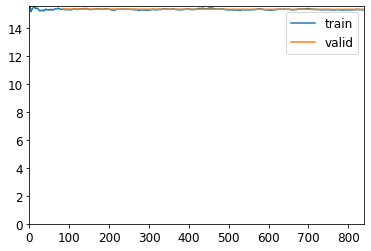

In [17]:
my_model = DotProductBias(n_users, n_items, n_factors, y_range=(0, 1.5))
learn_wd = MyLearner(dls, my_model, loss_func=MSELossFlat(), opt_func=Adam, lr=1e-3, cbs=[ShowGraphCallback()], wd=1e-3, sim_lambda=1e-2, l1_lambda=0., l2_lambda=0., decouple_wd=True) # wd, Adam
# Use sgd optimizer use following line
# learn_sgd = MyLearner(dls, my_model, loss_func=MSELossFlat(), opt_func=SGD, lr=1e-10, cbs=[ShowGraphCallback()], wd=0., sim_lambda=1e-2, l1_lambda=5e-3, l2_lambda=5e-3, decouple_wd=False) # sgd
learn_wd.fit(10)

## My model test

In [18]:
test_dls = dls.test_dl(test_df)
preds, labels = learn_wd.get_preds(dl=test_dls)

In [19]:
rows = []
for idx, (user, item, actual_y, pred_y) in enumerate(sorted(zip(test_df.dataset_name, test_df.pipeline_name, test_df.accuracy, preds), reverse=True)):
  actual, pred = test_df.accuracy.iloc[idx], float(preds[idx])
  rows.append(dict({'user': test_df.dataset_name.iloc[idx], 'item': test_df.pipeline_name.iloc[idx], 'actual_acc': actual, 'pred_acc': pred}))
test_result = pd.DataFrame(rows)
test_result.head()

,user,item,actual_acc,pred_acc
0,85_mux6,"['truncatedsvd', 'nusvc']",0.500000,0.660283
1,103_solar_flare_1,"['logisticregressionfeature', 'randomforestclassifier']",0.682540,0.760155
2,78_mofn_3_7_10,"['standardscaler', 'nusvc']",1.000000,0.973975
3,78_mofn_3_7_10,"['powertransformer', 'nusvc']",1.000000,0.976597
4,67_hungarian,"['gradientboostingclassifierfeature', 'adaboostclassifier']",0.847458,0.780051


In [20]:
# act, pre = np.array(test_result.actual_acc), np.array(test_result.pred_acc)
error_rates = np.absolute(np.divide(preds-labels, labels))
mean_acc = 1 - error_rates.mean()
float(mean_acc)

0.7053678035736084

# Result Analysis: Factors Histogram
Plot the Histogram of **user_factors** (dataset_factors) and **item_factors** (pipeline_factors)

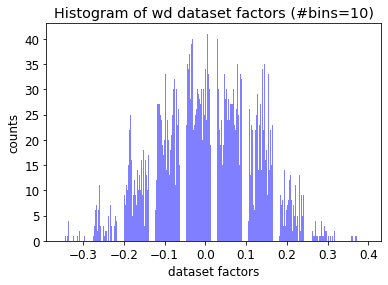

In [21]:
# (wd) dataset_factors Histogram
x = learn_wd.model.user_factors.detach().numpy()
num_bins = 10
# the histogram of the data
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5)

plt.xlabel('dataset factors')
plt.ylabel('counts')
plt.title('Histogram of wd dataset factors (#bins=10)')
plt.show()

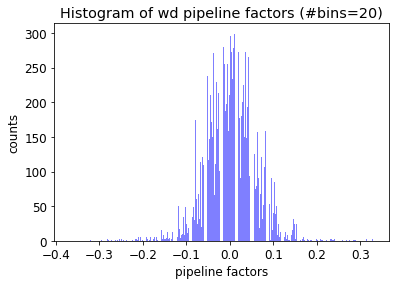

In [22]:
# (wd) pipeline_factors Histogram
x = learn_wd.model.item_factors.detach().numpy()
num_bins = 20
# the histogram of the data
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5)

# add a 'best fit' line
plt.xlabel('pipeline factors')
plt.ylabel('counts')
plt.title('Histogram of wd pipeline factors (#bins=20)')
plt.show()

# Result Analysis: Data Clustering

In [23]:
def text_clean(name, newline=False):
  substitutes = {"classifier": "Clas", "feature": "Feat", "gaussian": "Gaus", 
                "perceptron": "Percpt", "quadratic": "Quad", "polynomial": "Poly", 
                "ing": "", "multinomial": "Mltnom", "transformer": "Transf", 
                "transformation": "Transft", "threshold": "Thres", "neighbors": "Neigbs",
                 "gradient": "Grad", "standard": "Stad", "percentile": "Percent", 
                 "passive": "Pass", "aggressive": "Aggre", "elimination": "Elim", 
                 "discriminant": "Discrim", "analysis": "Analy", "random": "Rand", 
                 "variance": "Var", "decision": "Dec", "agglomeration": "Aggl", 
                 "trees": "Tre", "extra": "Extr", "additive": "Addi", "bernoullinb": "Bernlinb", 
                 "sampler": "Sampl"}
  for key, val in substitutes.items():
    name = name.replace(key, val)
  if not newline:
    return name
  
  # split add newline
  dataset_name = name.split(",")
  curr_i = ""
  if len(dataset_name) > 1:
    for name in dataset_name:
      curr_i += (name + '\n')
    curr_i = curr_i[:-1]
  else:
    curr_i = name
  return curr_i

In [24]:
# focus on specific (target) pipelines
g = data_df.groupby('pipeline_name')['accuracy'].count()
top_pipelines = list(g.sort_values(ascending=False).index.values[:830])
target_pipelines = ["['skewedchi2sampler', 'extratreesclassifierfeature', 'baggingclassifier']", 
                    "['skewedchi2sampler', 'mlpclassifierfeature', 'baggingclassifier']", 
                    "['normalizer', 'quantilescalinguniform', 'skewedchi2sampler', 'extratreesclassifier']", 
                    "['powertransformer', 'quantilescalinguniform', 'skewedchi2sampler', 'extratreesclassifier']"]
target_idx = []
for ppl in target_pipelines:
  target_idx.append(top_pipelines.index(ppl))
target_idx

[802, 776, 733, 751]

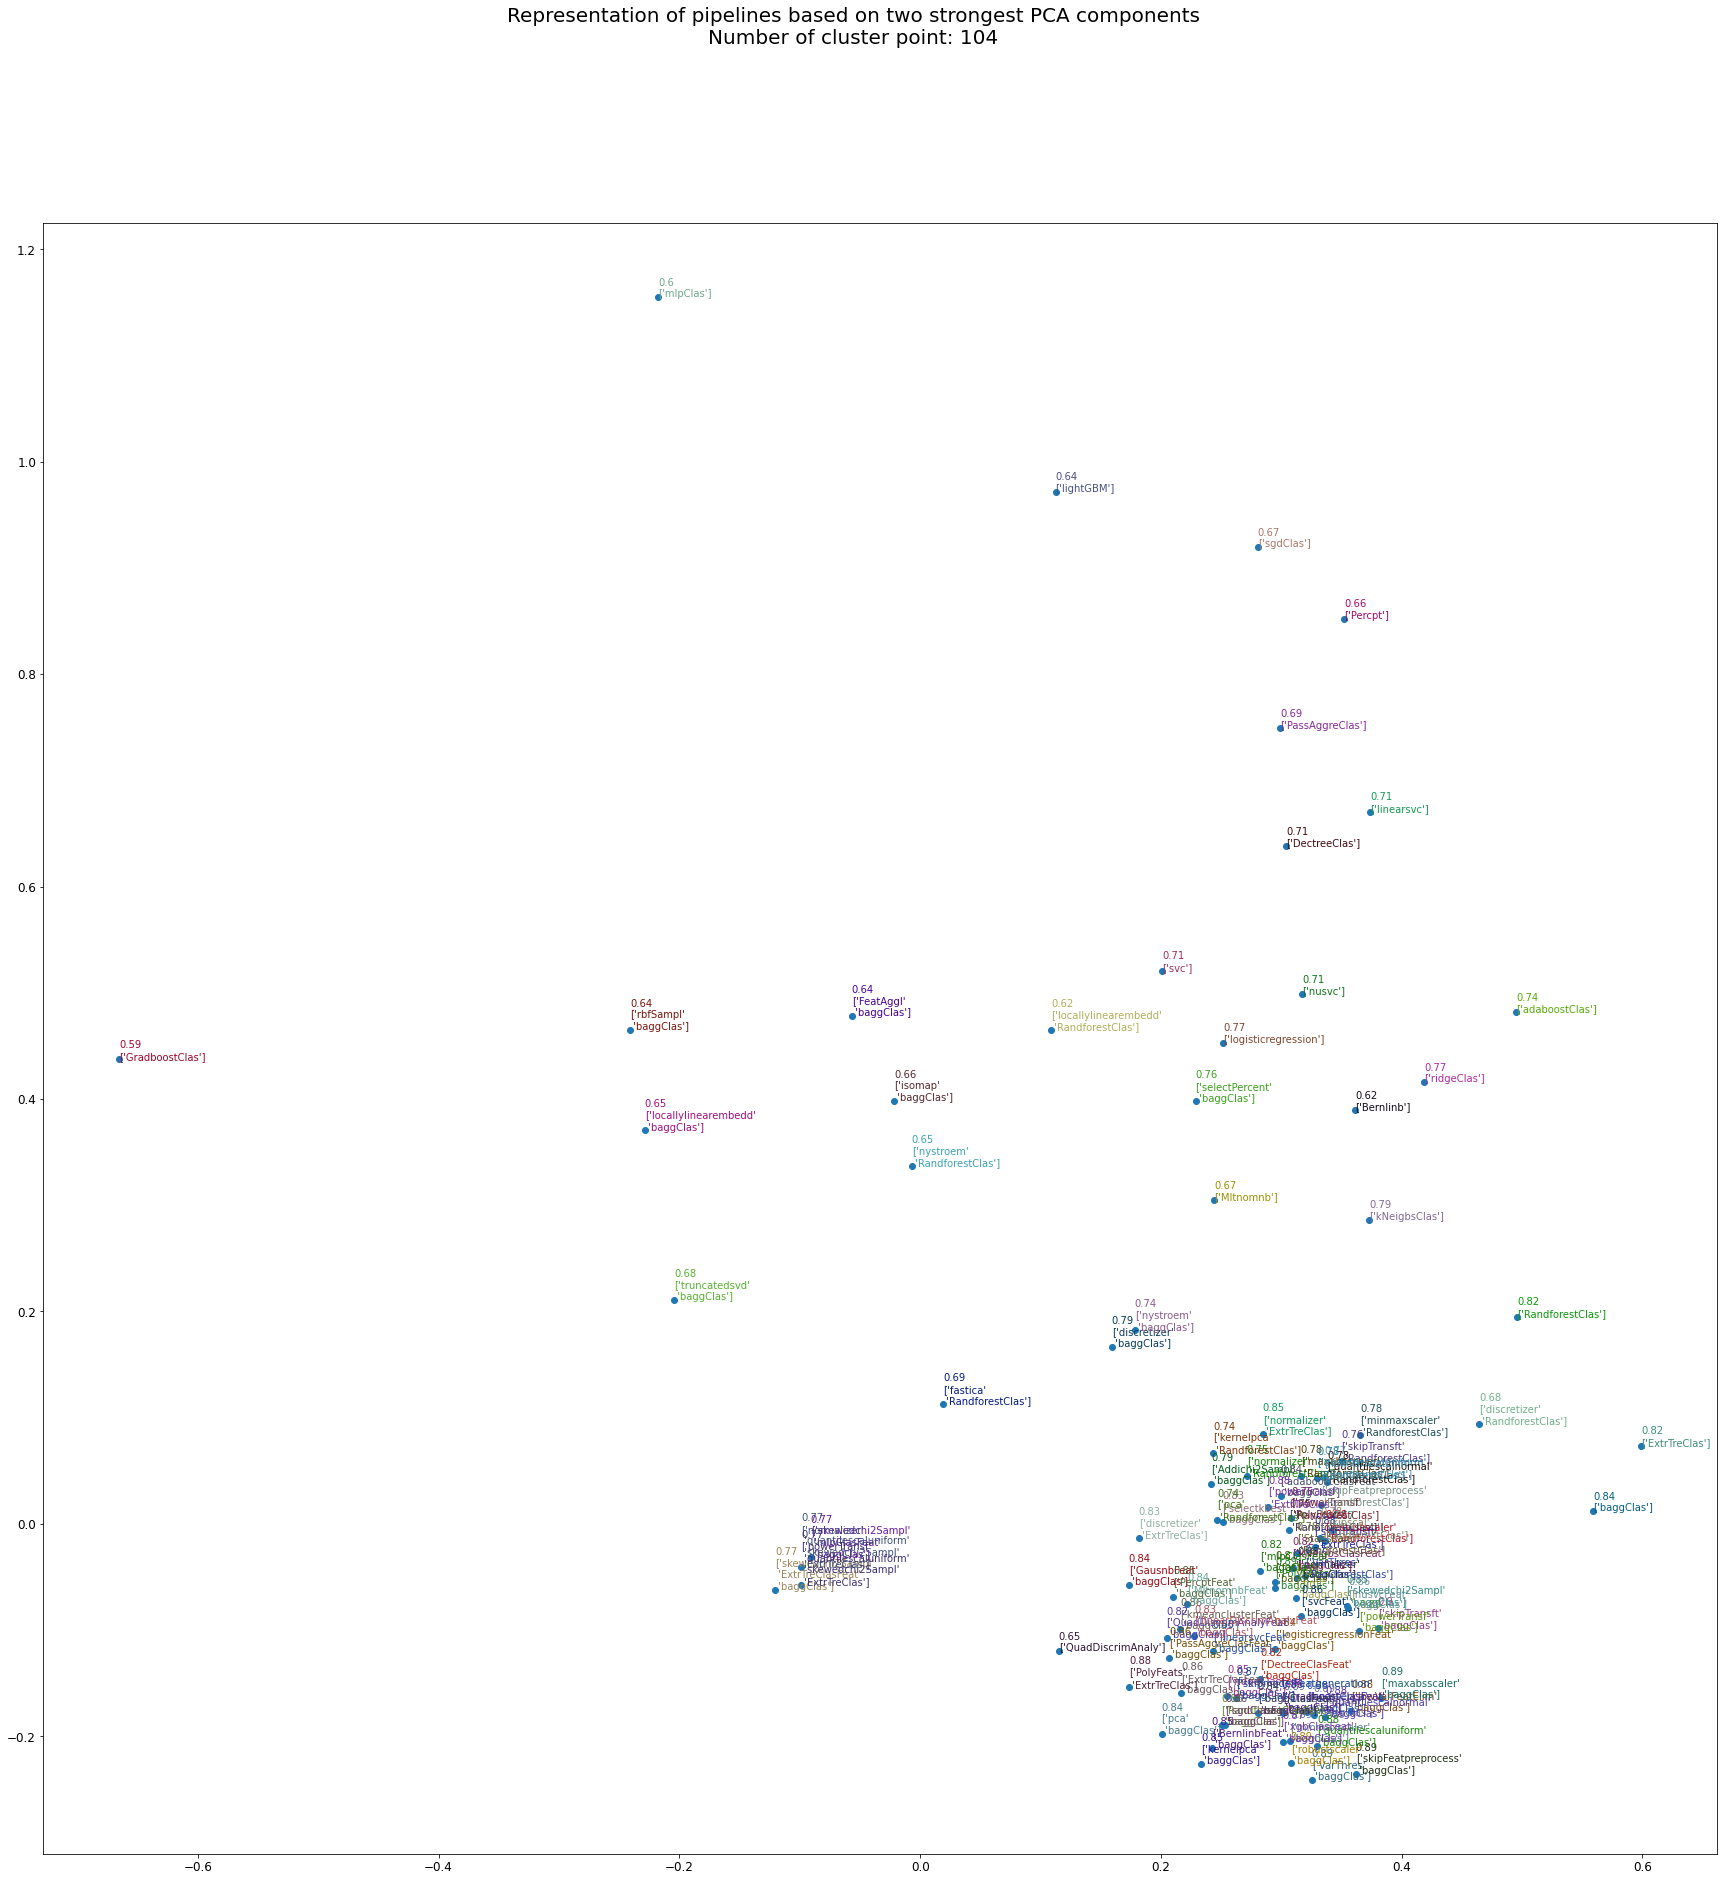

In [25]:
g = data_df.groupby('pipeline_name')['accuracy'].count()
acc_g = data_df.groupby('pipeline_name').mean() 
acc_dict = acc_g.to_dict('dict')['accuracy']

top_pipelines = g.sort_values(ascending=False).index.values[:830]
top_idxs = tensor([learn_wd.dls.classes['pipeline_name'].o2i[m] for m in top_pipelines])
pipeline_w = learn_wd.model.item_factors[top_idxs].cpu().detach() # pipeline_factors
pipeline_pca = pipeline_w.pca(3)
fac0,fac1,fac2 = pipeline_pca.t()
idxs = list(range(100)) # 50
# add pipeline idxs with 3 steps and 4 steps
idxs += target_idx

X = fac0[idxs]
Y = fac1[idxs] # Y = fac2[idxs]
fig = plt.figure(figsize=(30,30))
plt.scatter(X, Y)

cluster_point = 0
for i, x, y in zip(top_pipelines[idxs], X, Y):
  plt.text(x,y, str(round(acc_dict[i], 2)) + "\n" + text_clean(i, newline=True), color=np.random.rand(3)*0.7, fontsize=10)
  cluster_point += 1

fig.suptitle('Representation of pipelines based on two strongest PCA components' + '\n' + 'Number of cluster point: ' + str(cluster_point), fontsize=20)
plt.show()

# Result Analysis: Data Clustering (x, y) = (pipeline_bias, avg_accuracy)

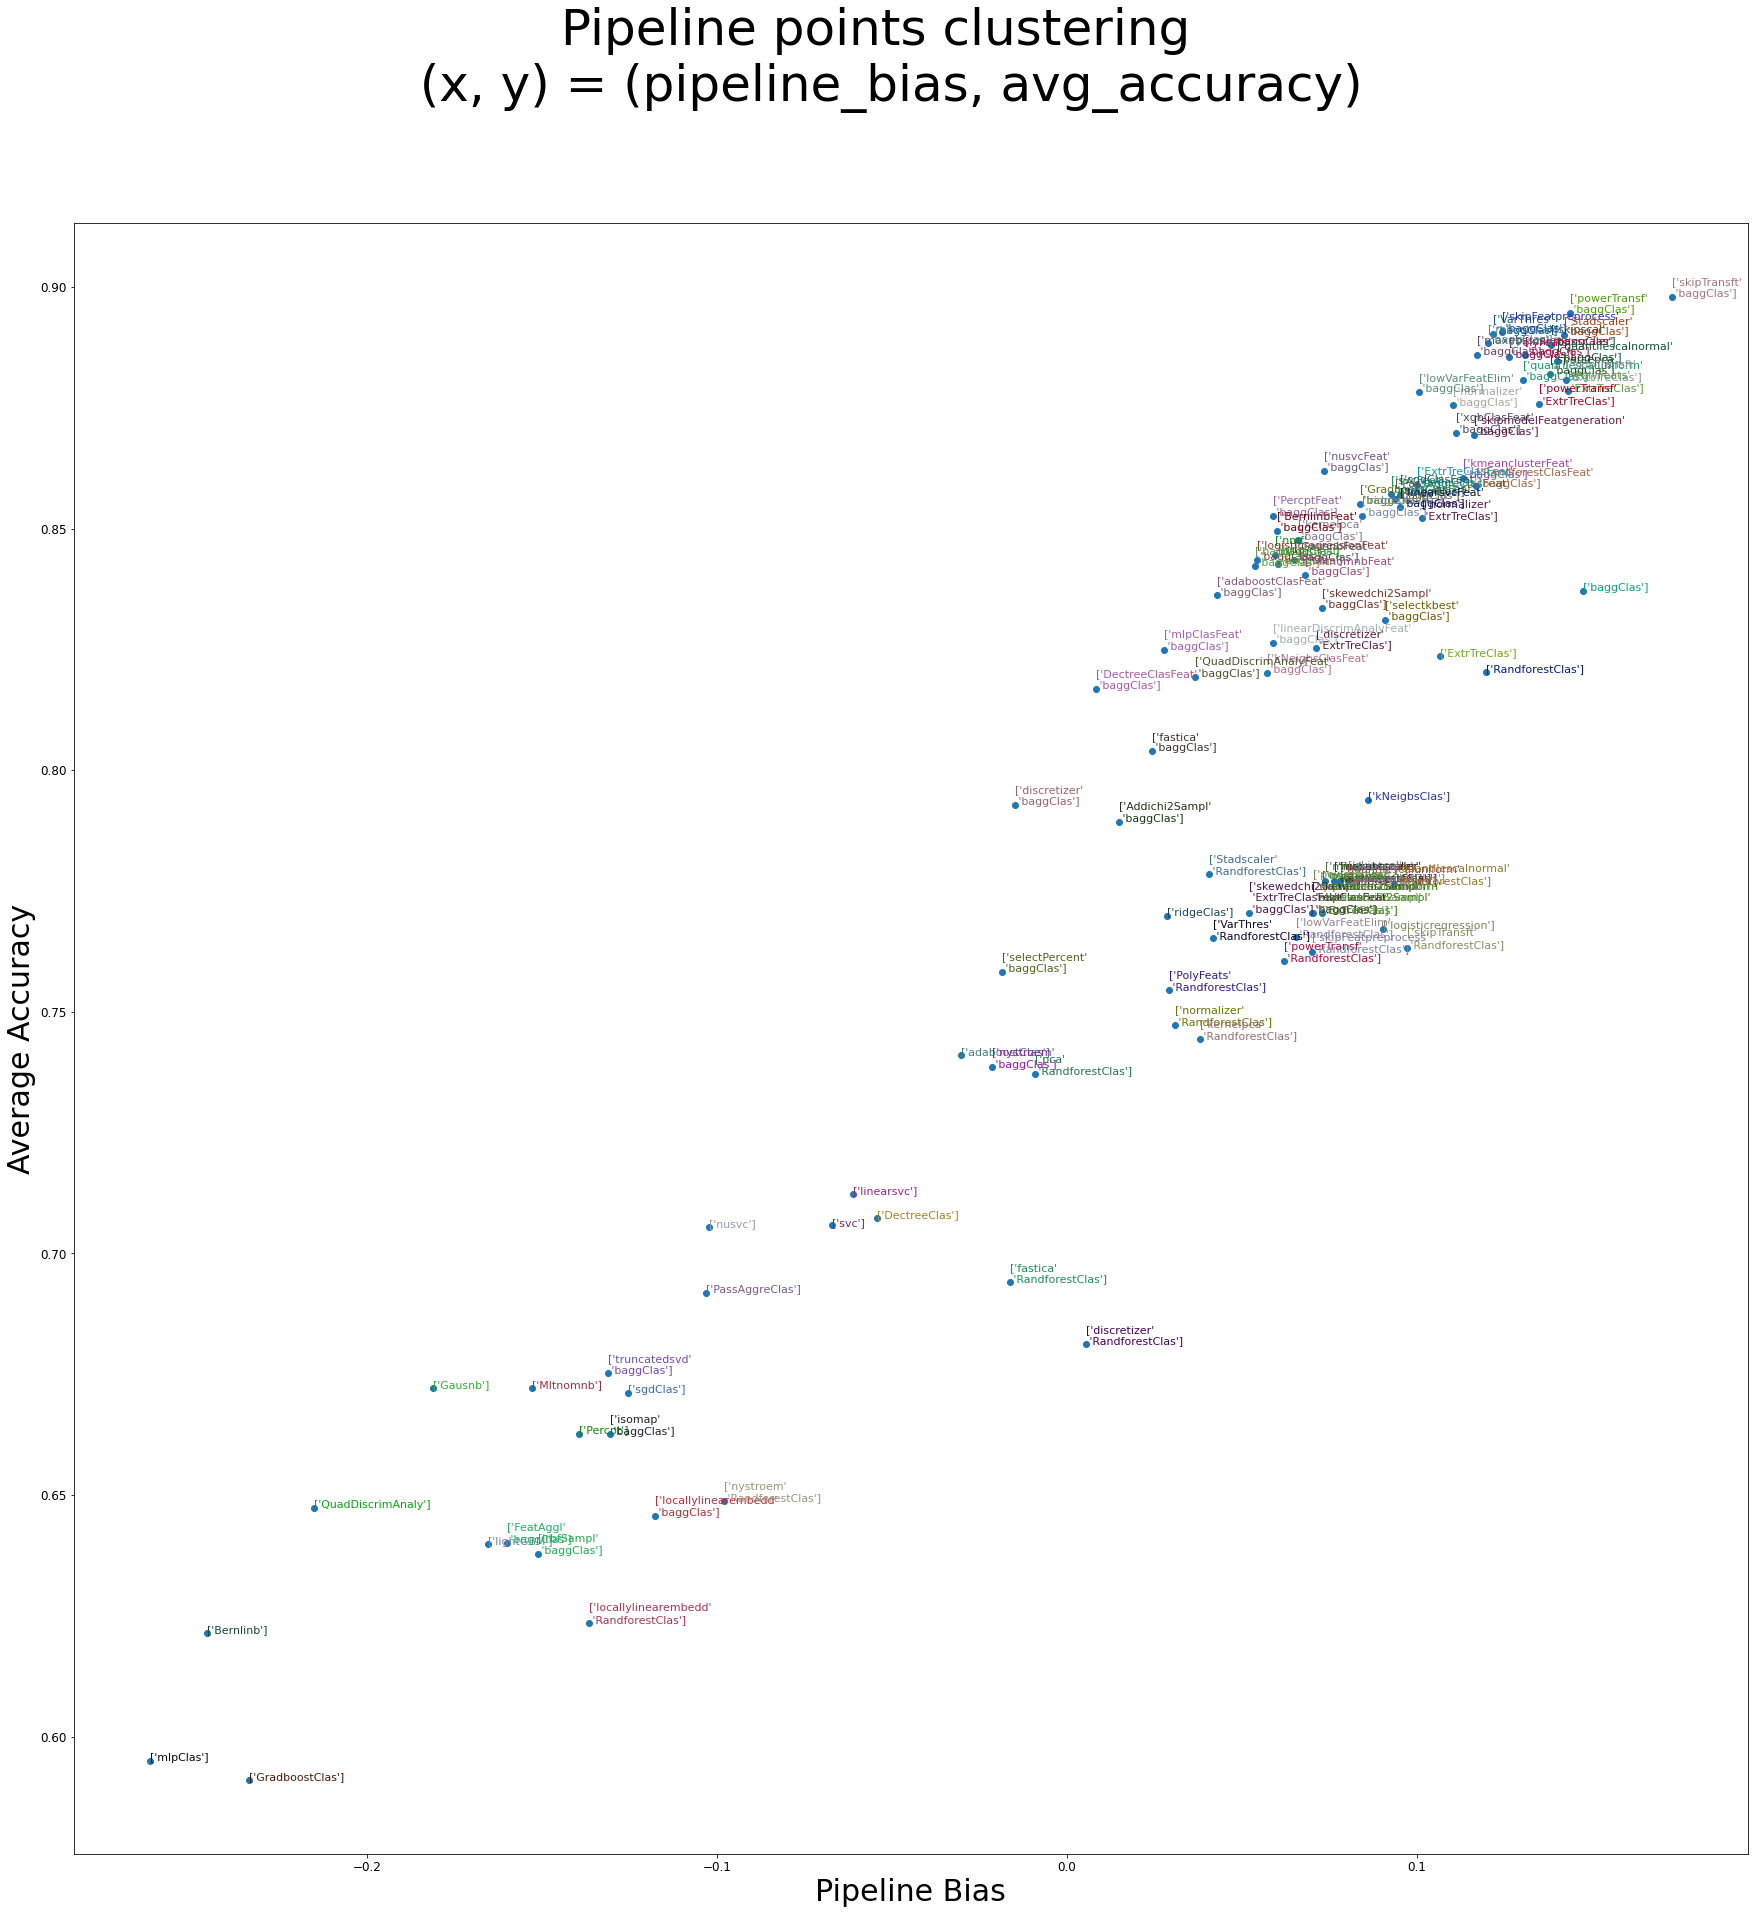

Number of cluster point:  104


In [28]:
g = data_df.groupby('pipeline_name')['accuracy'].count()
acc_g = data_df.groupby('pipeline_name').mean() 
acc_dict = acc_g.to_dict('dict')['accuracy']

all_pipelines = g.sort_values(ascending=False).index.values[:830] # include a distinct pipelines
all_idxs = tensor([learn_wd.dls.classes['pipeline_name'].o2i[m] for m in all_pipelines]) # occurance (keep)
pipeline_b = learn_wd.model.item_bias[all_idxs].cpu().detach()  # pipeline_bias

acc_tensor = []
for ppl in all_pipelines:
  acc_tensor.append(acc_dict[ppl])
acc_tensor =  torch.Tensor(acc_tensor)

idxs = list(range(100)) # 830: choose all pipeline (n: topN occurrence)
# add pipeline idxs with 3 steps and 4 steps
idxs += target_idx

X = pipeline_b[idxs]
Y = acc_tensor[idxs]

fig = plt.figure(figsize=(30,30))
plt.scatter(X, Y)
# add labels
fig.suptitle('Pipeline points clustering \n (x, y) = (pipeline_bias, avg_accuracy)', fontsize=50)
plt.xlabel('Pipeline Bias', fontsize=30)
plt.ylabel('Average Accuracy', fontsize=30)

cluster_point = 0
for i, x, y in zip(all_pipelines[idxs], X, Y):
  plt.text(x,y, text_clean(i, newline=True), color=np.random.rand(3)*0.7, fontsize=11)
  cluster_point += 1

plt.show()
print('Number of cluster point: ', cluster_point)